In [1]:
pip install keras_tuner

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import time
import nrrlib as ntl
from keras.backend import dropout
start_time = time.time()
import tensorflow as tf
import numpy as np
import random as rn

In [4]:
# random state
sd = 5
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)
tf.random.set_seed(sd)

In [5]:
# load das libs
# load das libs
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, Flatten, MaxPooling1D, LSTM, Bidirectional, GRU
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop 
from gensim.models import KeyedVectors
import sklearn.gaussian_process as gp
import numpy
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import json

import keras_tuner as kt #Bayesian Optimization tuner - hp [hiperparameters]


class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            self.score = roc_auc_score(self.y_val, y_pred)
            self.false_positive_rate, self.true_positive_rate, _ = roc_curve(self.y_val, y_pred)

In [6]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [7]:
# Load data
reviews = pd.read_csv('C:/Users/Diogo/Documents/faculdade/tcc/hatetag_not_hatetag.csv')

#print(reviews1.head)
print(reviews.head)

pd.set_option('display.max_colwidth',1000)

classe = [1 if each == 'hatetag' else 0 for each in reviews[' label']]
texto = reviews['tweet']

print('Dataset Loaded')
#test_tokenize(tokenize)
text_tokenized, text_tokenizer = ntl.tokenize(texto)

ntl.test_pad(ntl.pad)
test_pad = ntl.pad(text_tokenized)

target = classe
#y = pd.get_dummies(target).values
y = numpy.array(target)

preproc_texto, texto_tokenizer =\
    ntl.preprocess(texto)
    
max_text_length = preproc_texto.shape[1]
text_vocab_size = len(texto_tokenizer.word_index)

worddx = texto_tokenizer.word_index

print('Data Preprocessed')
print("Max sentence length:", max_text_length)
print("Vocabulary size:", text_vocab_size)

# parametros:
tam_vocab = text_vocab_size # vocabulário do embedding
tam_max = max_text_length # 100
batchsize = 16  # 64
embedding_dimen = 300  # 50 ! 300
filtros = 250 #250
kernel_size = 2 # 3 | 2
hidden_dims = 100 # not used
epochs = 50
lr = 0.0006 # 0.00006
drp = 0.4   # coeficiente de dropout

print(f'y é isso aqui: {y}')

X_train, X_test, y_train, y_test = train_test_split(test_pad, y, test_size=0.3)

#lr_schedule = optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=lr,
#    decay_steps=10000,
#    decay_rate=0.9)
#optimizer = Adam(learning_rate=lr_schedule)
#optimizer = SGD(learning_rate=lr_schedule)
#optimizer = Nadam(learning_rate=0.01)

start_time2 = time.time()
wvec = KeyedVectors.load_word2vec_format('C:/Users/Diogo/Documents/faculdade/tcc/cbow_s300.txt')
#wvec = KeyedVectors.load_word2vec_format("cbow_s50.txt")
#wvec = KeyedVectors.load_word2vec_format("skip_s50.txt")
print(); print("Time to load model: %.5s s.\n" % (time.time() - start_time2))

<bound method NDFrame.head of                                                    tweet        label
0      a primeira vez que um genocida presta solidari...      hatetag
1                      bolsonaro assassino de  mil vidas      hatetag
2      bolsonaro bosta bolsomerda bozolixo em realeng...      hatetag
3      bolsonaro nazista bozolixo mito mico lulalivre...      hatetag
4      bolsonaro nazista brasil fascismo nazismo bols...      hatetag
...                                                  ...          ...
31618  única coisa que atraio é os carros na hora que...  not_hatetag
31619                         única explicação plausível  not_hatetag
31620  única foto que tenho de ontem é uma minha e da...  not_hatetag
31621                 único  que eu respeito bozo elenão      hatetag
31622  único posicionamento possível da anitta neste ...  not_hatetag

[31623 rows x 2 columns]>
Dataset Loaded
Data Preprocessed
Max sentence length: 100
Vocabulary size: 39618
y é isso aqui: [1 1 1 

In [8]:
# gerando a matriz do embedding
embedding_matrix = np.zeros((tam_vocab+1, embedding_dimen))
for word, i in worddx.items():
    if i>=tam_vocab:
        continue
    try:
        embedding_vector = wvec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_dimen)


del(wvec)

# defininindo a camada de embedding utilizando a matriz
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=tam_max,
                            trainable=False)



del(embedding_matrix)

#    embedding_vec = embeddings_index.get(word)
#    if embedding_vec is not None:
#        embedding_matrix[index] = embedding_vec

In [9]:
def build_model(hp):
  model = Sequential()
  # primeira camada se trata do embedding. 
  model.add(embedding_layer)

  # input = numero de possiveis palavras, dimensão do espaço(complex!), e 137
  #model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 

  # camada convolucional
  # filtros referentes ao output dessa camada,
  # tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
  # padding 'valid' = sem padding
  # função de ativação = relu

  model.add(GRU(15, activation='tanh', return_sequences=True))
  model.add(Dropout(0.4))

  model.add(MaxPooling1D())

  model.add(GRU(10, activation='tanh'))
  model.add(Dropout(0.4))


  # nivela o output para utilização na camada densa
  model.add(Flatten())

  #model.add(Dense(2, activation='sigmoid')) #FUNÇÃO VAGABUNDA
  model.add(Dense(1, activation='sigmoid')) 

  hp_learning_rate = 0.01
  hp_optimizer = RMSprop(hp_learning_rate)

  '''
  if hp_optimizer == 'Adam':
    learning_rate = hp_learning_rate
  elif hp_optimizer == 'SGD':
    learning_rate = hp_learning_rate
    nesterov=True
    momentum=0.9
  elif hp_optimizer == 'Optimizer':
    hp_optimizer = optimizer'''



  # calculo de loss adotado = binary_crossentropy/categorical_crossentropy
  #model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
  model.compile(loss='binary_crossentropy', optimizer=hp_optimizer, metrics=['accuracy'])

  return model

tuner_cnn = kt.tuners.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='.',
    project_name='tuning-cnn')


print(X_train.shape)
#print(y_train.shape)
print(X_test.shape)
#print(y_test.shape)

# Fit the model                                                                                               #val split
# history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)
tuner_cnn.search(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_data=(X_test, y_test), validation_split = 0.3, verbose=1)

# Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

# tempo de execução total
print(); print("Tempo de execução: %.5s segundos.\n" % (time.time() - start_time))

# plot dos gráficos
# ntl.plot_accuracy(history)
# ntl.plot_loss(history)

INFO:tensorflow:Reloading Oracle from existing project .\tuning-cnn\oracle.json
INFO:tensorflow:Reloading Tuner from .\tuning-cnn\tuner0.json
(22136, 100)
(9487, 100)
INFO:tensorflow:Oracle triggered exit

Tempo de execução: 134.1 segundos.



In [10]:
best_model = tuner_cnn.get_best_models()[0]
best_hp = tuner_cnn.get_best_hyperparameters(1)[0]
print('Modelo ideal:\n')
best_hp.values

Modelo ideal:



{}

In [11]:
best_acc = tuner_cnn.oracle.get_best_trials()[0].score

In [12]:
best_hpp = tuner_cnn.get_best_hyperparameters(1)[0]

In [13]:
#se for pra dar load

#opt_model = tf.keras.models.load_model('best_model.h5')
#history = opt_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=1, callbacks = [EarlyStopping(monitor='val_loss', patience=10),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)])

In [14]:
resultados = pd.read_csv('../resultados.csv')

opt_model = tuner_cnn.hypermodel.build(best_hpp)

# ra_val = RocAucEvaluation(validation_data=(X_test, y_test), interval = 1)

# csv_logger = CSVLogger('log.csv', append=False, separator=';')

# history = opt_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=8),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True), ra_val, csv_logger], validation_split = 0.3, verbose=2)


# scores = opt_model.evaluate(X_test, y_test, verbose=1)

# y_predito = opt_model.predict(X_test).round()  
# y_gabarito = y_test

# # Parâmetros
# # rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
# NOME_REDE = "V15"
# NOME_BASE = 'PADRAO'
# NOME_OTIMIZADOR = 'RMSProp'
# ACURACIA = scores[1]
# LOSS = scores[0] 
# LEARNING_RATE = 0.01
# DROPOUT_RATE = 0.4
# BATCH = batchsize
# ROC_CURVE = json.dumps({
#     "false_positive_rate": list(ra_val.false_positive_rate),
#     "true_positive_rate": list(ra_val.true_positive_rate),
#     "score": ra_val.score})
# TRAIN_RESUME = json.dumps(pd.read_csv('log.csv',sep=';').to_dict()) 

# confusion = confusion_matrix(y_gabarito, y_predito)
# CONFUSION_MATRIX = json.dumps({
#     "00": int(confusion[0][0]),
#     "01": int(confusion[0][1]),
#     "10": int(confusion[1][0]),
#     "11": int(confusion[1][1])
# })

# EPOCHS = len(history.history['val_loss'])
# RANK = ACURACIA/LOSS

# # Salvando resultado do modelo
# registro_resultado = {resultados.columns[0]: NOME_REDE, 
#                         resultados.columns[1]: NOME_BASE, 
#                         resultados.columns[2]: NOME_OTIMIZADOR,
#                         resultados.columns[3]: ACURACIA, 
#                         resultados.columns[4]: LOSS,
#                         resultados.columns[5]: LEARNING_RATE,
#                         resultados.columns[6]: DROPOUT_RATE,
#                         resultados.columns[7]: BATCH,
#                         resultados.columns[8]: ROC_CURVE,
#                         resultados.columns[9]: TRAIN_RESUME,
#                         resultados.columns[10]: CONFUSION_MATRIX,
#                         resultados.columns[11]: EPOCHS,
#                         resultados.columns[12]: RANK,
#                     }

# resultados = resultados.append(registro_resultado, ignore_index=True)

# resultados.to_csv('../resultados.csv')

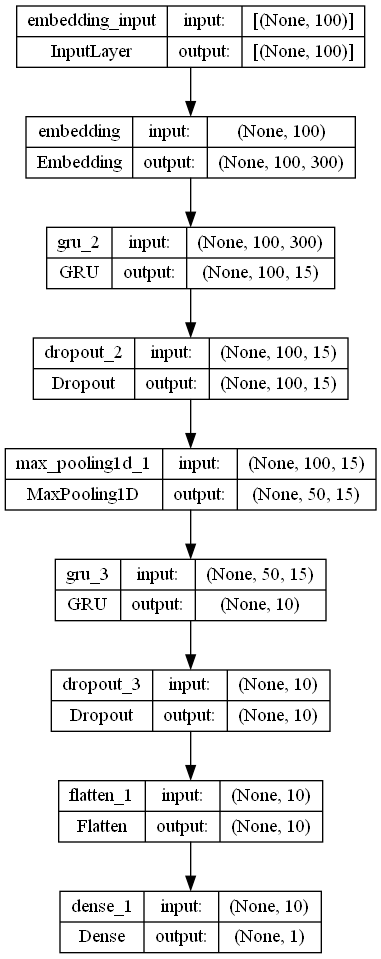

In [15]:
# Final evaluation of the model
import pydot

tf.keras.utils.plot_model(opt_model, to_file='v15.png', show_shapes=True)
# scores = opt_model.evaluate(X_test, y_test, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# # plot dos gráficos
# ntl.plot_accuracy(history)
# ntl.plot_loss(history)